In [1]:
import numpy as np
import pandas as pd

import math
import matplotlib.pyplot as plt
%matplotlib inline

# figure size shit
textwidth=6.50127
fig_width = textwidth/2
golden_mean = (math.sqrt(5)-1.0)/2.0
fig_height = fig_width*golden_mean

#datapath = "Z:/hcs/data/ipeds/"
datapath = "/Users/tarasullivan/Google Drive File Stream/My Drive/research/hcs/data/ipeds/"
namepath = "/Users/tarasullivan/Google Drive File Stream/My Drive/research/hcs/data/ipeds/cip_edit"

Create dictionaries for 2-digit and 4-digit CIP codes

In [2]:
# Create 2-digit CIP code dictionary
# Read in variable names
df = pd.read_stata(namepath + '/cip2names.dta')

# set index 
df = df.set_index('cip2')

# remove periods; change capitalization
df['ciptitle2010'] = df['ciptitle2010'].str.replace('.','')
df['ciptitle2010'] = df['ciptitle2010'].str.capitalize()

# specific edits
df.loc['01'] = 'Agriculture and related sciences'
df.loc['05'] = 'Group studies'
df.loc['09'] = 'Communcation'
df.loc['10'] = 'Communications technologies' #Communications technologies and support services
df.loc['11'] = 'Information services' #Computer and information services
df.loc['15'] = 'Engineering technologies'
df.loc['16'] = 'Foreign languages'
df.loc['19'] = 'Family and consumer sciences'
df.loc['24'] = 'Liberal arts'
df.loc['26'] = 'Biological sciences'
df.loc['30'] = 'Interdisciplinary studies'
df.loc['43'] = 'Law enforcement'#'Law enforcement and protective services'
df.loc['51'] = 'Health professions'
df.loc['52'] = 'Business' # 'Business and related services'

# to dictionary
cip2dict = df.to_dict()['ciptitle2010']

In [3]:
# Create 4-digit CIP code dictionary
# Read in variable names
df = pd.read_stata(namepath + '/cip4names.dta')

# create 2-digit CIP code
df['cip2'] = df['cip4'].str[:2]

# remove periods; change capitalization
df['ciptitle2010'] = df['ciptitle2010'].str.replace('.','')
df['ciptitle2010'] = df['ciptitle2010'].str.capitalize()

# set index; create dataframe
cip4df = df.set_index(['cip2', 'cip4'])

# to create dictionary:
#cip4df.loc['01'].to_dict()['ciptitle2010']

Read in raw time-series data. Make basic edits. 

In [4]:
# read in raw data
df = pd.read_stata(datapath + '/ipeds_c_all.dta')

In [5]:
# remove rows with missing cipcode in 2010
df = df[df['cipcode2010'] != '']

# keep only bachelor's degrees
df = df[df['awlevel'] == 5]

# drop aggregate values
df = df[(df['cipcode'] != '99') & (df['cipcode'] != '99.') &
        (df['cipcode'] != '99.0000') & (df['cipcode'] != '95.0000') &
        (df['cipcode'] != '95.9500')]

# make year an integer
df['year'] = df['year'].astype(int)

# check if there are duplicated values according to original cip code
# note that these may be aggregated
assert False == df.duplicated(subset=
                              ['year', 'unitid', 'cipcode', 'majornum']).any()

In [6]:
# aggregate over cipcode2010, majornum; reset index
df = df.groupby(['year','unitid','cipcode2010']).aggregate('sum')

# remove columns
df = df.drop(['awlevel', 'majornum'], axis=1)

# reset index
df = df.reset_index()
df.head()

,year,unitid,cipcode2010,ctotalm,ctotalw
0,1990,100654,01.0102,5.0,0.0
1,1990,100654,01.0901,0.0,1.0
2,1990,100654,01.1001,3.0,2.0
3,1990,100654,01.1103,1.0,0.0
4,1990,100654,01.1201,2.0,0.0


In [7]:
# Create 2-digit and 4-digit CIP codes

# Create 2-digit CIP code column
df2 = df
# Create 2-digit CIP code
df2['cip2'] = df2['cipcode2010'].str[:2]
# aggregate to two digit level
df2 = df2.groupby(['year','unitid','cip2']).aggregate('sum')
# reset index
df2 = df2.reset_index()

# Create 4-digit CIP code column
df4 = df
# Create 4-digit CIP code
df4['cip4'] = df4['cipcode2010'].str[:5]
# aggregate to two digit level
df4 = df4.groupby(['year','unitid','cip4']).aggregate('sum')
# reset index
df4 = df4.reset_index()
# Create 2-digit CIP code
df4['cip2'] = df4['cip4'].str[:2]

Number of Bachelor's degrees by men and women

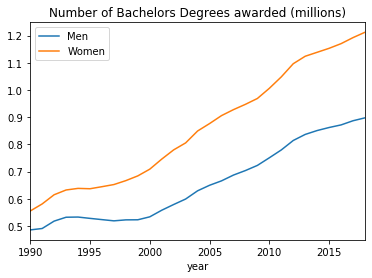

In [8]:
fig = plt.figure()
ax = plt.axes()

df.groupby(['year']).aggregate('sum').transform(lambda x: x/1e6).plot(ax=ax)

ax.set_title('Number of Bachelors Degrees awarded (millions)')

label_dict = {'ctotalm' : 'Men', 'ctotalw' : 'Women'}
handles, labels_list = ax.get_legend_handles_labels()
ax.legend(list(map(label_dict.get, labels_list)))

Totals of 2-digit CIP codes for men and women

In [9]:
# list of top 20 2-digit cip codes
cip2_2018 = df2.groupby(['year','cip2']).aggregate('sum').loc[2018]

# save values of top 20 index
top20 = cip2_2018.sum(axis=1).sort_values(ascending=False).iloc[:20].index.values
top12 = cip2_2018.sum(axis=1).sort_values(ascending=False).iloc[:12].index.values

In [10]:
# top 12 cip codes, aggregated
cip2df = df2[df2['cip2'].isin(top12)].groupby(['year','cip2']).aggregate('sum').unstack()

# switch order of columns
cip2df.columns = cip2df.columns.swaplevel(0,1)
cip2df.sort_index(axis=1, level=0, inplace = True)

cip2df = cip2df/1e3

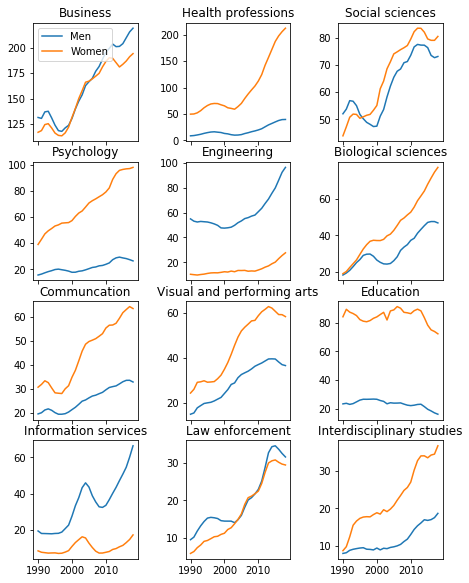

In [11]:
fig, ax = plt.subplots(4,3,sharex='col')

# Figure size shit 

fig_width = textwidth/2
golden_mean = (math.sqrt(5)-1.0)/2.0
fig_height = fig_width*golden_mean
fig.set_size_inches(2*fig_width,4*fig_height)

fig.tight_layout() 

for i in range(4):
    for j in range(3):
        k = i*3+j
        ax[i,j].plot(cip2df[top12[k]])
        ax[i,j].set_title(cip2dict[top12[k]])

# create legend (bug necessitates awkward language)
ax[0,0].legend(list(map(label_dict.get, cip2df[top12[0]].columns.to_list())))

Healthcare (CIP=51) 
* How much is nursing
* Breakdown of other occupations

### Nursing (CIP = 51)

In [12]:
# create mapping that you want to use 
cip51nurse = {'Nursing' : ['51.38', '51.39'],}

# invert mapping
cip51map = {}
for key, value in cip51nurse.items():
    for cip in value:
        cip51map.update({cip : key})     

# copy dataset; convert to thousands
cip51 = df4[df4['cip2']=='51'].copy()
# create group variable
cip51['group'] = cip51['cip4'].map(cip51map).fillna('Other')
# aggregate by the group
cip51 = cip51.groupby(['year', 'group']).aggregate('sum').unstack()
# convert to thousands
cip51 = cip51/1e3

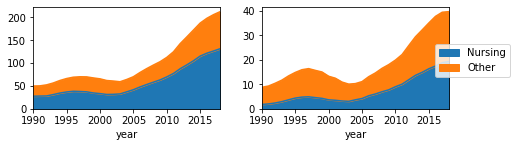

In [13]:
fig, ax = plt.subplots(1,2)

# Figure size shit 
fig_width = textwidth/2
golden_mean = (math.sqrt(5)-1.0)/2.0
fig_height = fig_width*golden_mean
fig.set_size_inches(2*fig_width,fig_height)

fig.tight_layout() 

cip51['ctotalw'].plot.area(ax=ax[0],legend=None)
cip51['ctotalm'].plot.area(ax=ax[1],legend=None)

#ax[0].legend(None)
handles, labels = ax[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right',bbox_to_anchor=(1.1, 0.6))

What does the breakdown of other positions look like? 

In [14]:
# copy dataset; convert to thousands
cip51 = df4[(df4['cip2']=='51')].copy()
cip51 = cip51[(cip51['cip4'] != '51.38') & (cip51['cip4'] != '51.39')]
# create group variable
# aggregate by the group
cip51 = cip51.groupby(['year', 'cip4']).aggregate('sum').unstack()
# convert to thousands
cip51 = cip51/1e3

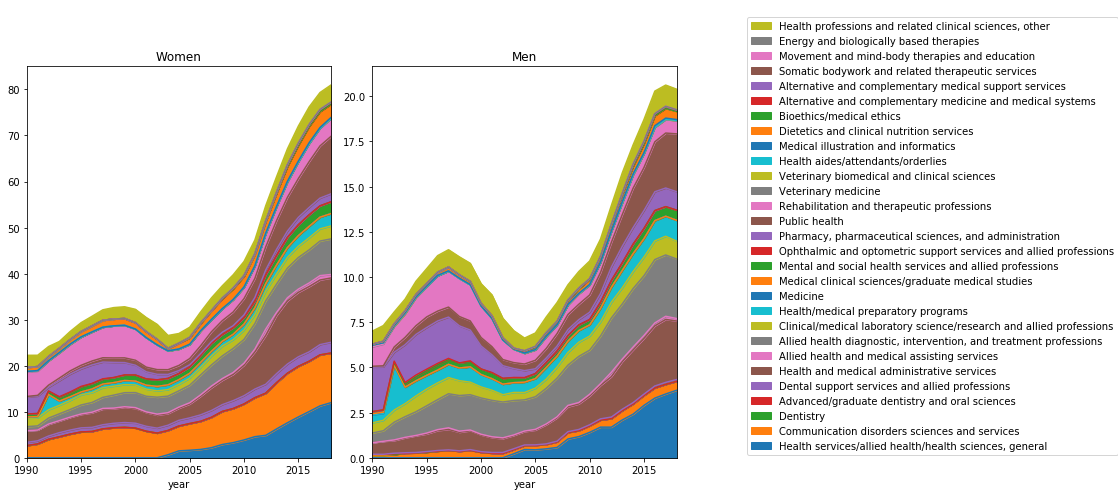

In [15]:
fig, ax = plt.subplots(1,2)

# Figure size shit 
fig.set_size_inches(3*fig_width,3*fig_height)

fig.tight_layout() 

cip51['ctotalw'].plot.area(ax=ax[0],legend=None)
cip51['ctotalm'].plot.area(ax=ax[1],legend=None)

ax[0].set_title('Women')
ax[1].set_title('Men')

#ax[0].legend(None)
handles, labels = ax[1].get_legend_handles_labels()
txt_labels = list(map(cip4df.loc['51'].to_dict()['ciptitle2010'].get, labels))
fig.legend(handles[::-1], txt_labels[::-1], loc='center right',bbox_to_anchor=(1.6, .6))

### General program by CIP code

In [171]:
def cipgraph(cip,cipdict={},shareyflag=True):
    '''Return a figure with a stacked area graph for particular CIP codes
    '''
    
    # if relevant, pass dictionary
    if len(cipdict)!=0:
        #Invert map
        cipmap = {}
        for key, value in cipdict.items():
            for cipcode4 in value:
                cipmap.update({cipcode4 : key})

        # create dataframe for all cip4 that replaces with ciptitle if not defined
        cip_desc = cip4df.loc[cip].reset_index()
        # create variable 
        cip_desc['group'] = cip_desc['cip4'].map(cipmap)
        cip_desc['group'] = cip_desc.group.fillna(cip_desc['ciptitle2010'])
        # drop title column
        cip_desc = cip_desc.drop(['ciptitle2010'],axis=1)
        # create as a dictionary that can be mapped 
        cip_mapdict = cip_desc.set_index('cip4').to_dict()['group']
    
    # Create dataset 
    # copy relevant portion of the dataset
    cipdf = df4.loc[df4['cip2']==cip].copy()
    # create group variable
    if len(cipdict)!=0:
        groupvar = 'group'
        cipdf['group'] = cipdf['cip4'].map(cip_mapdict)
    else:
        groupvar = 'cip4'
    # aggregate by the group
    cipdf = cipdf.groupby(['year',groupvar]).aggregate('sum').unstack()
    # convert to thousands
    cipdf = cipdf/1e3
    # find the maximum value in dataframe; add 5% to be consistent with matplotlib
    maxval = (cipdf.stack().groupby(['year']).aggregate('sum').values.max())*1.05
    
    # Create figure
    fig, ax = plt.subplots(1,2,sharey=shareyflag)

    #fig.set_size_inches(3*fig_width,3*fig_height)

    cipdf['ctotalw'].plot.area(ax=ax[0],legend=None)
    cipdf['ctotalm'].plot.area(ax=ax[1],legend=None)

    ax[0].set_title('Women')
    ax[1].set_title('Men')
    
    if shareyflag == True:
        ax[0].set_ylim((0, maxval))
    
    fig.suptitle(cip2dict[cip])

    handles, labels = ax[0].get_legend_handles_labels()
    if len(cipdict)!=0:
        txt_labels = labels
    else:
        txt_labels = list(map(cip4df.loc[cip].to_dict()['ciptitle2010'].get, labels))
    fig.legend(handles[::-1], txt_labels[::-1], loc='center left',bbox_to_anchor=(.9,.6),borderaxespad=0)
    
    plt.show()

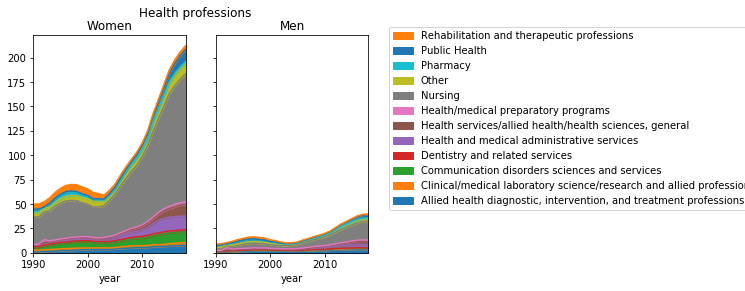

In [125]:
# create mapping that you want to use 
cip51dict = {'Nursing' : ['51.38', '51.39'],
              'Dentistry and related services' : ['51.04', '51.05', '51.06'],
             #'Veterinary medicine' : ['51.24', '51.25'],
              'Pharmacy' : ['51.20'],
              'Public Health' : ['51.22'],
              'Other' : ['51.08','51.12','51.14','51.15','51.18','51.24', '51.25','51.26','51.27','51.31','51.32','51.33','51.34','51.35','51.36','51.37','51.99'],
             }
cipgraph('51',cip51dict)

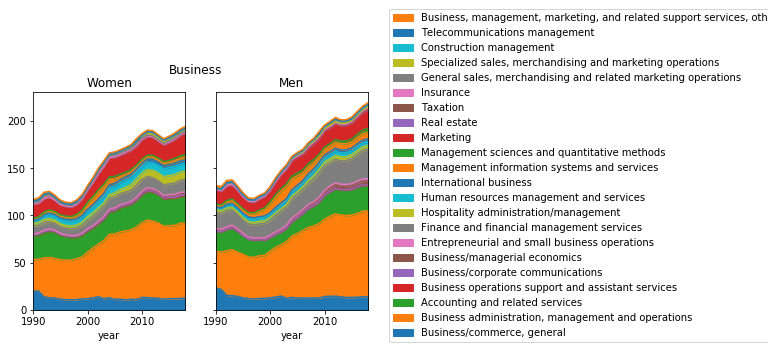

In [73]:
cipgraph('52')

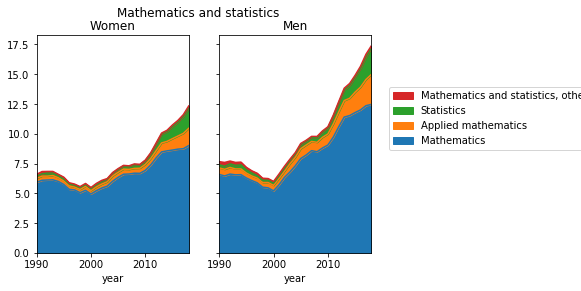

In [58]:
cipgraph('27')

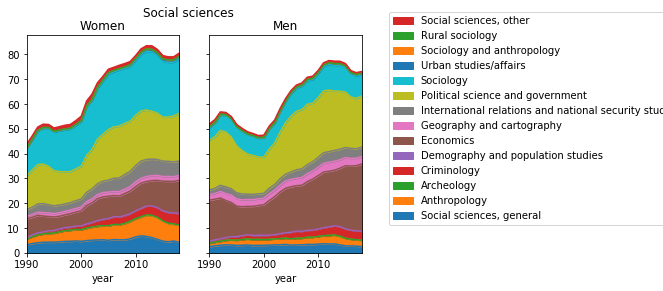

In [55]:
cipgraph('45')

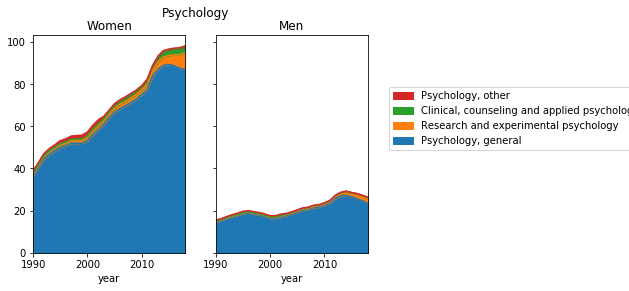

In [62]:
cipgraph('42')

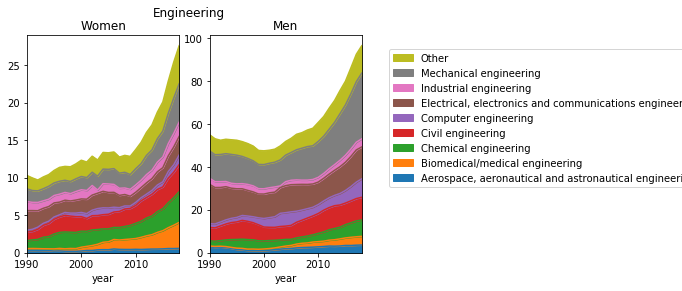

In [198]:
cip14dict = {'Other' : [
                        '14.01','14.03','14.04','14.06',
                        '14.11','14.12','14.13','14.14','14.18',
                        '14.20','14.21','14.22','14.23','14.24','14.25','14.27','14.28',
                        '14.32','14.33','14.34','14.36','14.37','14.38','14.39',
                        '14.40','14.41','14.42', '14.43','14.44','14.45',
                        '14.99'
                        ]}

cipgraph('14',cip14dict,shareyflag=False)

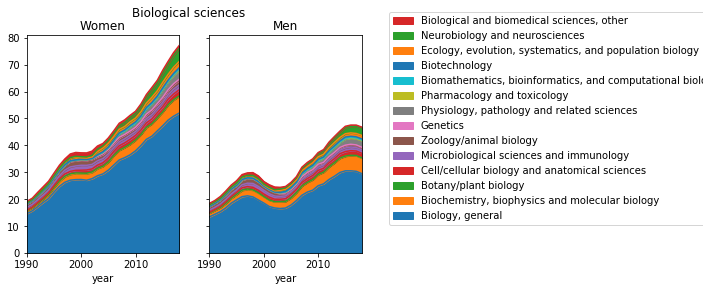

In [201]:
cipgraph('26')

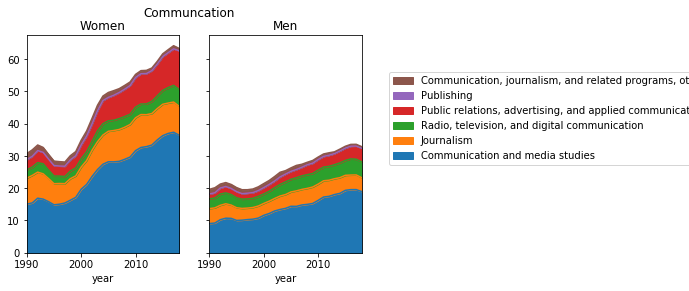

In [204]:
cipgraph('09')

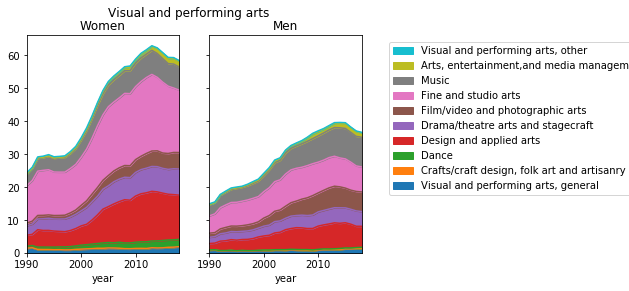

In [207]:
cipgraph('50')

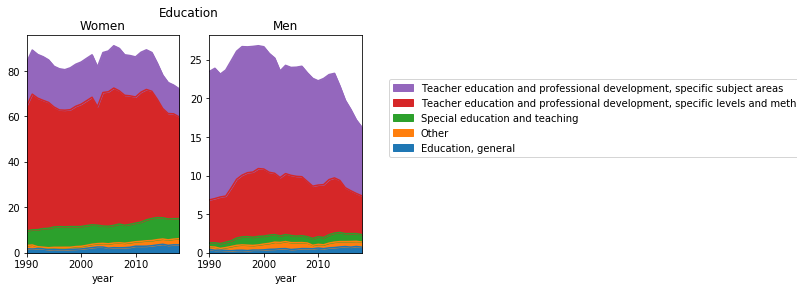

In [215]:
cip13dict = {'Other' : ['13.02','13.03','13.04','13.05','13.06','13.07','13.09','13.11','13.14','13.15','13.99']}
cipgraph('13',cip13dict,shareyflag=False)

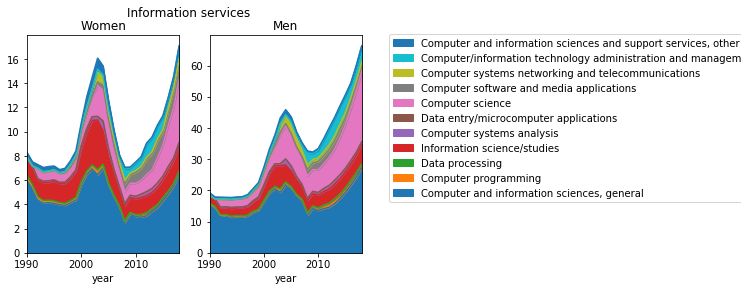

In [218]:
cipgraph('11',shareyflag=False)

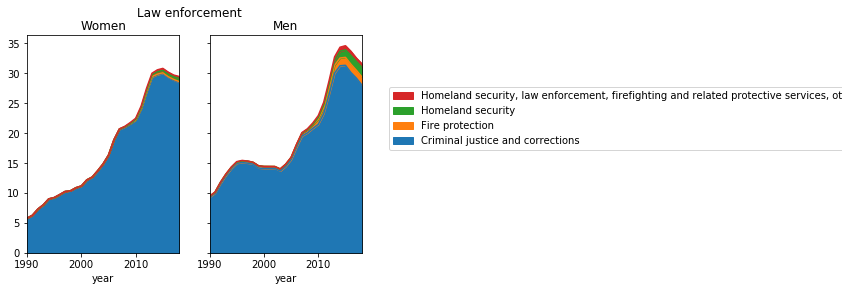

In [220]:
cipgraph('43')

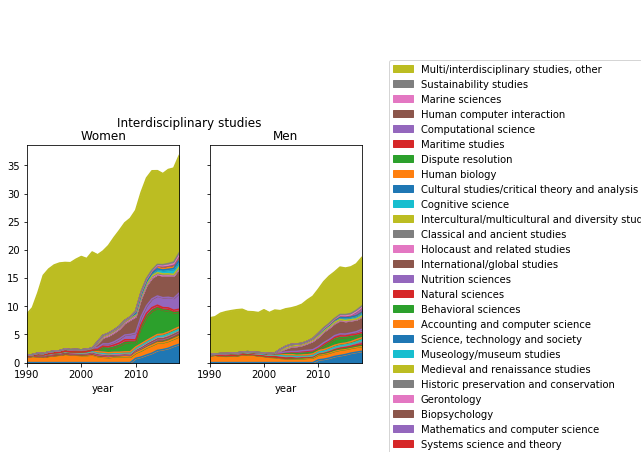

In [222]:
cipgraph('30')

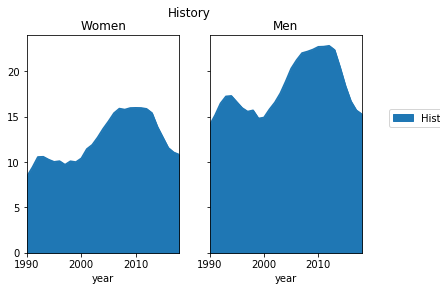

In [229]:
cipgraph('54')